![CMCC](http://cmcc.ufabc.edu.br/images/logo_site.jpg)
# ** Análise Exploratória **

#### Esse notebook introduz os conceitos de Análise Exploratória

#### Para isso utilizaremos a base de dados de [Crimes de São Francisco](https://www.kaggle.com/c/sf-crime) obtidos do site de competições [Kaggle](https://www.kaggle.com/).

#### ** Esse notebook contém:  **
#### *Parte 1:* *Parsing* da base de dados de Crimes de São Francisco
#### *Parte 2:* Estatísticas Básicas das Variáveis
#### *Parte 3:* Plotagem de Gráficos

#### Para os exercícios é aconselhável consultar a documentação da [API do PySpark](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD)

### ** Parte 1: Parsing da Base de Dados **

#### Nessa primeira parte do notebook vamos aprender a trabalhar com arquivos CSV. Os arquivos CSV são arquivos textos representando tabelas de dados, numéricas ou categóricas, com formatação apropriada para a leitura estruturada.

#### A primeira linha de um arquivo CSV é o cabeçalho, com o nome de cada coluna da tabela separados por vírgulas.

#### Cada linha subsequente representa um objeto da base de dados com os valores também separados por vírgula. Esses valores podem ser numéricos, categóricos (textuais) e listas. As listas são representadas por listas de valores separadas por vírgulas e entre aspas.

#### Vamos carregar a base de dados histórica de Crimes de São Francisco, um dos temas do projeto final. No primeiro passo vamos armazenar o cabeçalho em uma variável chamada `header` e imprimi-la para a descrição dos campos de nossa base.

In [1]:
import os
import numpy as np
from pyspark import SparkContext
sc = SparkContext()

filename = os.path.join("Data","Aula03","Crime.csv")
CrimeRDD = sc.textFile(filename,8)
header = CrimeRDD.take(1)[0] # o cabeçalho é a primeira linha do arquivo

print "Campos disponíveis: {}".format(header)

Campos disponíveis: Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y


#### Durante os exercícios precisaremos pular a linha do cabeçalho de tal forma a trabalhar apenas com a tabela de dados.

#### Uma forma de fazer isso é utilizando o comando `filter()` para eliminar toda linha igual a variável `header`.

In [2]:
# EXERCICIO
CrimeHeadlessRDD = CrimeRDD.filter(lambda x:x!=header)#<COMPLETAR>

firstObject = CrimeHeadlessRDD.take(1)[0]
print firstObject

2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747


In [3]:
assert firstObject==u'2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747', 'valor incorreto'
print "OK"

OK


#### Agora temos um dataset em que cada linha é uma string contendo todos os valores. Porém, para explorarmos os dados precisamos que cada objeto seja uma lista de valores.

#### Utilize o comando `split()` para transformar os objetos em listas de strings.

In [4]:
# EXERCICIO
CrimeHeadlessRDD = (CrimeRDD.filter(lambda x: x!=header).map(lambda y: y.split(",")))
                    #.map(lambda x: x!= header)#<COMPLETAR>
                    #.map(lambda y: y.split()#<COMPLETAR>
                    #)

firstObjectList = CrimeHeadlessRDD.take(1)[0]
print firstObjectList

[u'2015-05-13 23:53:00', u'WARRANTS', u'WARRANT ARREST', u'Wednesday', u'NORTHERN', u'"ARREST', u' BOOKED"', u'OAK ST / LAGUNA ST', u'-122.425891675136', u'37.7745985956747']


In [5]:
assert firstObjectList[0]==u'2015-05-13 23:53:00', 'valores incorretos'
print "OK"

OK


#### Reparem que o campo *Resolution* cujo valor no primeiro registro era "ARREST, BOOKED" se tornou dois campos diferentes por causa do `split()`.

#### Nesses casos em que uma simples separação não funciona, nós podemos utilizar as [Expressões Regulares](http://www.rexegg.com/regex-quickstart.html). O Python tem suporte as Regex através da biblioteca `re`. Vamos utilizar o comando [`re.split()`](https://docs.python.org/2/library/re.html#re.split) para cuidar da separação de nossa base em campos.

#### Além disso, vamos aproveitar para converter o primeiro campo, que representa data e hora, para objeto do tipo [`datetime`](https://docs.python.org/2/library/datetime.html) através do comando `datetime.datetime.strptime()`. Também vamos agrupar as coordenadas X e Y em uma tupla de floats.

#### Outra ajuda que o Python pode nos dar é a utilização das [`namedtuple`](https://docs.python.org/2/library/collections.html#namedtuple-factory-function-for-tuples-with-named-fields) que permite acessar cada campo de cada objeto pelo nome. Ex.: rec.Dates.

In [6]:
# EXERCICIO

import re
import datetime
from collections import namedtuple

headeritems = header.split(',') # transformar o cabeçalho em lista
del headeritems[-1] # apagar o último item e...
headeritems[-1] = 'COORD' # transformar em COORD

# Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,COORD
Crime = namedtuple('Crime',headeritems) # gera a namedtuple Crime com os campos de header

REGEX = r',(?=(?:[^"]*"[^"]*")*(?![^"]*"))'
# buscar por "," tal que após essa vírgula (?=) ou exista um par de "" ou não tenha " sozinha
# ?= indica para procurarmos pelo padrão após a vírgula
# ?: significa para não interpretar os parênteses como captura de valores
# [^"]* 0 ou sequências de caracteres que não sejam aspas
# [^"]*"[^"]*"  <qualquer caracter exceto aspas> " <qualquer caracter exceto aspas> "
# ?! indica para verificar se não existe tal padrão a frente da vírgula


def ParseCrime(rec):
    # utilizando re.split() vamos capturar nossos valores
    Date, Category, Descript, DayOfWeek, PdDistrict, Resolution, Address, X, Y = re.split(REGEX,rec)#<COMPLETAR>
    
    # Converta a data para o formato datetime
    Date = datetime.datetime.strptime(Date, "%Y-%m-%d %H:%M:%S")
    
    # COORD é uma tupla com floats representando X e Y
    COORD = (X,Y)#<COMPLETAR>
    
    # O campos 'Resolution' será uma lista dos valores separados por vírgula, sem as aspas
    Resolution = Resolution.split(",")#<COMPLETAR>
    return Crime(Date, Category, Descript, DayOfWeek, PdDistrict, Resolution, Address, COORD)

# Aplique a função ParseCrime para cada objeto da base
#CrimeHeadlessRDD = (CrimeRDD.map(ParseCrime)
#                    .<COMPLETAR>
#                    .<COMPLETAR>
#                    )
CrimeHeadlessRDD = CrimeRDD.filter(lambda x: x!=header).map(ParseCrime)


firstClean = CrimeHeadlessRDD.take(1)[0]
totalRecs = CrimeHeadlessRDD.count()
print firstClean

Crime(Dates=datetime.datetime(2015, 5, 13, 23, 53), Category=u'WARRANTS', Descript=u'WARRANT ARREST', DayOfWeek=u'Wednesday', PdDistrict=u'NORTHERN', Resolution=[u'"ARREST', u' BOOKED"'], Address=u'OAK ST / LAGUNA ST', COORD=(u'-122.425891675136', u'37.7745985956747'))


In [8]:
assert type(firstClean.Dates) is datetime.datetime and type(firstClean.Resolution) is list and type(firstClean.COORD) is tuple,'tipos incorretos' 
print "OK"

assert CrimeHeadlessRDD.filter(lambda x: len(x)!=8).count()==0, 'algo deu errado!' 
print "OK"

assert totalRecs==878049, 'total de registros incorreto' 
print "OK"

OK
OK
OK


### ** Parte 2: Estatísticas Básicas das Variáveis **

#### Nessa parte do notebook vamos aprender a filtrar a base de dados para calcular estatísticas básicas necessárias para a análise exploratória.

#### ** (2a) Contagem de frequência **

#### A contagem de frequência é realizada de forma similar ao exercício de contagem de palavras. Primeiro mapeamos a variável de interesse. Como exemplo vamos gerar uma lista da quantidade total de cada tipo de crime (Category).

In [9]:
# EXERCICIO
from operator import add
CatCountRDD = CrimeHeadlessRDD.map(lambda x:(x.Category,1)).reduceByKey(add)
               #.<COMPLETAR>
               #.<COMPLETAR>
               #)
#contagemFinal = (palavrasRDD.map(lambda x:(x,1)).reduceByKey(add)
catCount = sorted(CatCountRDD.collect(), key=lambda x: -x[1])
print catCount

[(u'LARCENY/THEFT', 174900), (u'OTHER OFFENSES', 126182), (u'NON-CRIMINAL', 92304), (u'ASSAULT', 76876), (u'DRUG/NARCOTIC', 53971), (u'VEHICLE THEFT', 53781), (u'VANDALISM', 44725), (u'WARRANTS', 42214), (u'BURGLARY', 36755), (u'SUSPICIOUS OCC', 31414), (u'MISSING PERSON', 25989), (u'ROBBERY', 23000), (u'FRAUD', 16679), (u'FORGERY/COUNTERFEITING', 10609), (u'SECONDARY CODES', 9985), (u'WEAPON LAWS', 8555), (u'PROSTITUTION', 7484), (u'TRESPASS', 7326), (u'STOLEN PROPERTY', 4540), (u'SEX OFFENSES FORCIBLE', 4388), (u'DISORDERLY CONDUCT', 4320), (u'DRUNKENNESS', 4280), (u'RECOVERED VEHICLE', 3138), (u'KIDNAPPING', 2341), (u'DRIVING UNDER THE INFLUENCE', 2268), (u'RUNAWAY', 1946), (u'LIQUOR LAWS', 1903), (u'ARSON', 1513), (u'LOITERING', 1225), (u'EMBEZZLEMENT', 1166), (u'SUICIDE', 508), (u'FAMILY OFFENSES', 491), (u'BAD CHECKS', 406), (u'BRIBERY', 289), (u'EXTORTION', 256), (u'SEX OFFENSES NON FORCIBLE', 148), (u'GAMBLING', 146), (u'PORNOGRAPHY/OBSCENE MAT', 22), (u'TREA', 6)]


In [10]:
assert catCount[0][1]==174900, 'valores incorretos'
print "OK"

OK


#### De forma similar, vamos gerar a contagem para as regiões de São Francisco (PdDistrict).

In [11]:
# EXERCICIO

RegionCountRDD = CrimeHeadlessRDD.map(lambda x:(x.PdDistrict,1)).reduceByKey(add)
                 # .<COMPLETAR>
                 # .<COMPLETAR>
                 #)
regCount = sorted(RegionCountRDD.collect(), key=lambda x: -x[1])
print regCount

[(u'SOUTHERN', 157182), (u'MISSION', 119908), (u'NORTHERN', 105296), (u'BAYVIEW', 89431), (u'CENTRAL', 85460), (u'TENDERLOIN', 81809), (u'INGLESIDE', 78845), (u'TARAVAL', 65596), (u'PARK', 49313), (u'RICHMOND', 45209)]


In [12]:
assert regCount[0][1]==157182, 'valores incorretos'
print "OK"

OK


#### **(2b) Cálculo da Média**

#### Nesse exercício vamos calcular a média de crimes em cada região para cada dia da semana. Para isso, primeiro devemos calcular a quantidade de dias de cada dia da semana que existem na base de dados, para isso vamos criar uma RDD de tuplas em que o primeiro campo é a tupla da data no formato 'dia-mes-ano' e do dia da semana e o segundo campo o valor $1$.

#### Em seguida, reduzimos a RDD sem efetuar a soma, mantendo o valor $1$. Essa redução filtra a RDD para que cada data apareça uma única vez. Ao final,  podemos efetuar o mapeamento de (DayOfWeek,1) e redução com soma para contabilizar quantas vezes cada dia da semana aparece na base de dados.

#### Nossa próxima RDD terá como chave uma tupla ( (DayOfWeek, PdDistrict), 1) para contabilizar quantos crimes ocorreram em determinada região e naquele dia da semana. Após a redução, devemos mapear esse RDD para (DayOfWeek, (PdDistrict, contagem)).

#### Finalmente, podemos juntar as duas RDDs uma vez que elas possuem a mesma chave (DayOfWeek), dessa forma teremos tuplas no formato ( DayOfWeek, ( (PdDistrict,contagem), contagemDiaDaSemana ) ). Isso deve ser mapeado para:

#### ( DayOfWeek, ( PdDistrict, contagem / contagemDiaDaSemana ) )

#### Lembrando de converter `contagemDiaDaSemana` para `float`. Finalmente, o resultado pode ser agrupado pela chave, gerando uma tupla ( DayOfWeek, [ (Pd1, media1), (Pd2, media2), ... ] ). Essa lista pode ser mapeada para um dicionário com o comando `dict`.

#### No final, transformamos o RDD em um dicionário Python com o comando `collectAsMap()`.

In [70]:
# EXERCICIO

from operator import add

# Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,COORD

# Lambda para converter um datetime em `Dia-Mes-Ano`
day2str = lambda x: '{}-{}-{}'.format(x.day,x.month,x.year)

totalDatesRDD = CrimeHeadlessRDD.map(lambda x : ((day2str(x.Dates),x.DayOfWeek),1)).reduceByKey(lambda y,z:y).map(lambda a: (a[0][1],1)).reduceByKey(add)

                 #.<COMPLETAR>
                 #.<COMPLETAR>
                 #.<COMPLETAR>
                 #.<COMPLETAR>
                 #)


crimesWeekDayRegionRDD = CrimeHeadlessRDD.map(lambda x:((x.DayOfWeek,x.PdDistrict),1)).reduceByKey(add).map(lambda (y,z):(y[0],(y[1],z)))
#                           .<COMPLETAR>
#                           .<COMPLETAR>
#                           .<COMPLETAR>
#                          )





RegionAvgPerDayRDD = (crimesWeekDayRegionRDD
                      .join(totalDatesRDD)
                      .map(lambda ( dow, ( (pd,c), cds ) ):( dow,  (pd, c / float(cds))))#<COMPLETAR>
                      .groupByKey()#<COMPLETAR>
                      .map(lambda x:(x[0],dict(x[1])))#<COMPLETAR>                      
                     )


                      
RegionAvg = RegionAvgPerDayRDD.collectAsMap()
print RegionAvg['Sunday']

{u'CENTRAL': 37.99688473520249, u'NORTHERN': 44.45794392523364, u'SOUTHERN': 64.82866043613707, u'PARK': 20.70404984423676, u'MISSION': 49.45171339563863, u'TENDERLOIN': 31.707165109034268, u'RICHMOND': 18.968847352024923, u'TARAVAL': 25.953271028037385, u'INGLESIDE': 32.230529595015575, u'BAYVIEW': 37.27414330218068}


In [71]:
assert np.round(RegionAvg['Sunday']['BAYVIEW'],2)==37.27, 'valores incorretos {}'.format(np.round(RegionAvg[0][2],2))
print "OK"

OK


#### ** (2c) Média e Desvio-Padrão pelo PySpark **

#### Uma alternativa para calcular média, desvio-padrão e outros valores descritivos é utilizando os comandos internos do Spark. Para isso é necessário gerar uma RDD de listas de valores.

#### Gere uma RDD contendo a tupla ( (Dates,DayOfWeek, PdDistrict), contagem), mapeie para ( (DayOfWeek,PdDistrict), Contagem) e agrupe pela chave. Isso irá gerar uma RDD ( (DayOfWeek,PdDistrict), Iterador(contagens) ).

#### Agora crie um dicionário RegionAvgSpark, inicialmente vazio e colete apenas o primeiro elemento da tupla para a variável `Keys`. Itere essa variável realizando os seguintes passos:

* #### Se `key[0]` não existir no dicionário, crie a entrada `key[0]` como um dicionário vazio.
* #### Mapeie countWeekDayDistRDD filtrando por `key` e gerando a RDD com os valores da tupla. Note que não queremos uma lista de listas.
* #### Insira a tupla (media, desvio-padrão) utilizando os comandos `mean()` e `stdev()` do PySpark, armazenando na chave RegionAvgSpark[ key[0] ][ key[1] ].

In [92]:
# EXERCICIO

countWeekDayDistRDD = (CrimeHeadlessRDD.map(lambda x:((day2str(x.Dates),x.DayOfWeek,x.PdDistrict),1))
                       .reduceByKey(add)
                       .map(lambda ((d,dow,pd),c):((dow,pd),c))#<COMPLETAR>
                       .groupByKey()#<COMPLETAR>
                       #.<COMPLETAR>
                       #.<COMPLETAR>
                       )

# Esse procedimento só é viável se existirem poucas chaves
RegionAvgSpark = {}
Keys = countWeekDayDistRDD.map(lambda rec: rec[0]).collect()
for key in Keys:
    listRDD = (countWeekDayDistRDD
               .filter(lambda rec: rec[0]==key)
               .flatMap(lambda rec: rec[1])
               )
    if key[0] not in RegionAvgSpark:
        RegionAvgSpark[key[0]] = {}    
    RegionAvgSpark[key[0]][key[1]] = (listRDD.mean(), listRDD.stdev())
    
print RegionAvgSpark['Sunday']

{u'CENTRAL': (38.115625000000016, 9.7147957188700076), u'NORTHERN': (44.59687500000007, 9.6090772311588299), u'PARK': (20.768749999999997, 8.7925550005388029), u'SOUTHERN': (65.03124999999996, 14.36333086152025), u'MISSION': (49.60625, 11.166409939523984), u'TENDERLOIN': (31.806249999999984, 10.109399632891163), u'RICHMOND': (19.028125, 6.1858575787335264), u'TARAVAL': (26.034374999999994, 7.5561692251679355), u'INGLESIDE': (32.23052959501557, 8.1948507519816935), u'BAYVIEW': (37.39062500000002, 10.061400852235984)}


In [93]:
assert np.round(RegionAvgSpark['Sunday']['BAYVIEW'][0],2)==37.39 and np.round(RegionAvgSpark['Sunday']['BAYVIEW'][1],2)==10.06, 'valores incorretos'
print "OK"

OK


### Parte 3: Plotagem de Gráficos

#### Nessa parte do notebook vamos aprender a manipular os dados para gerar listas de valores a serem utilizados na plotagem de gráficos.

#### Para a plotagem de gráficos vamos utilizar o [`matplotlib`](http://matplotlib.org/) que já vem por padrão na maioria das distribuições do Python (ex.: Anaconda). Outras bibliotecas alternativas interessantes são: [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/) e [Bokeh](http://bokeh.pydata.org/en/latest/).

#### ** (3a) Gráfico de Barras **

#### O gráfico de barras é utilizado quando queremos comparar dados entre categorias diferentes de uma variável categórica. Como exemplo, vamos contabilizar o número médio de crimes diários por região.

#### Vamos primeiro criar a RDD totalDatesRDD que contém a lista de dias únicos, computaremos o total de dias com o comando `count()` armazenando na variável `totalDays`. Não se esqueça de converter o valor para `float`.

#### Em seguida, crie o RDD avgCrimesRegionRDD que utiliza a RDD RegionCountRDD para calcular a média de crimes por região.

#### Utilizando o comando `zip()` do Python é possível descompactar um dicionário em duas variáveis, uma com as chaves e outra com os valores. Utilizaremos essas variáveis para a plotagem do gráfico.

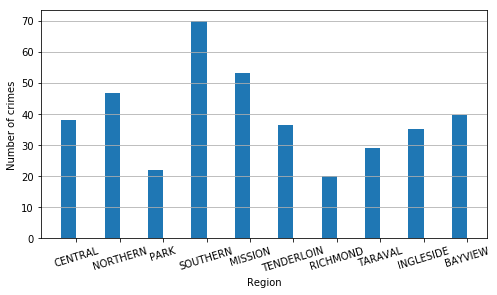

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

# Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,COORD

# Lambda para converter um datetime em `Dia-Mes-Ano`
day2str = lambda x: '{}-{}-{}'.format(x.day,x.month,x.year)

totalDatesRDD = (CrimeHeadlessRDD
                 .map(lambda rec: (day2str(rec.Dates),1))
                 .reduceByKey(lambda x,y: x)
                 )

totalDays = float(totalDatesRDD.count())

avgCrimesRegionRDD = (RegionCountRDD
                      .map(lambda rec: (rec[0],rec[1]/totalDays))
                     )

Xticks,Y = zip(*avgCrimesRegionRDD.collectAsMap().items())
indices = np.arange(len(Xticks))
width = 0.35

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.bar(indices,Y, width)
plt.grid(b=True, which='major', axis='y')
plt.xticks(indices+width/2., Xticks, rotation=17 )
plt.ylabel('Number of crimes')
plt.xlabel('Region')
pass

#### Quando temos subcategorias de interesse, podemos plotar através de um gráfico de barras empilhado. Vamos plotar o conteúdo da variável RegionAvg.

#### Primeiro passo é criar um dicionário `Y` em que a chave é o dia da semana e o valor é uma `np.array` contendo a média de cada região para aquele dia.

#### Em seguida precisamos criar uma matriz `Bottom` que determina qual é o início de cada uma das barras. O início da barra do dia `i` deve ser o final da barra do dia `i-1`.

#### Com isso calculado podemos gerar um plot por dia com o parâmetro bottom correspondente ao vetor `Bottom` daquele dia.

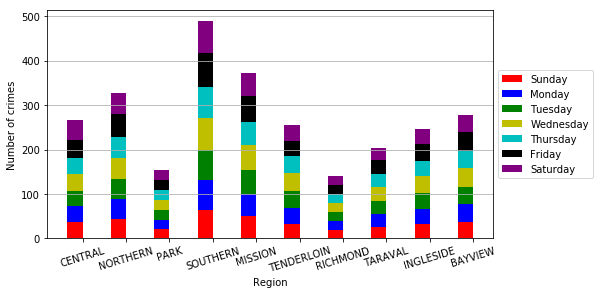

In [76]:
# Dias da semana como referência
Day = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

# Uma cor para cada dia
Color = ['r','b','g','y','c','k','purple']

# Dicionário (dia, array de médias)
Y = {}
for day in Day:
    Y[day] = np.array([RegionAvg[day][x] for x in Xticks])

# Matriz dias x regiões    
Bottom = np.zeros( (len(Day),len(Xticks)) )
for i in range(1,len(Day)):
    Bottom[i,:] = Bottom[i-1,:]+Y[Day[i-1]]
    
indices = np.arange(len(Xticks))
width = 0.35

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')

# Gera uma lista de plots, um para cada dia
plots = [plt.bar(indices,Y[Day[i]], width, color=Color[i], bottom=Bottom[i]) for i in range(len(Day))]

plt.legend( [p[0] for p in plots], Day,loc='center left', bbox_to_anchor=(1, 0.5) ) 
    
plt.grid(b=True, which='major', axis='y')
plt.xticks(indices+width/2., Xticks, rotation=17 )
plt.ylabel('Number of crimes')
plt.xlabel('Region')
pass

#### ** (3b) Gráfico de Linha **

#### O gráfico de linha é utilizado principalmente para mostrar uma tendência temporal.

#### Nesse exercício vamos primeiro gerar o número médio de crimes em cada hora do dia.

#### Primeiro, novamente, geramos um RDD contendo um único registro de cada hora para cada dia. Em seguida, contabilizamos a soma da quantidade de crime em cada hora. Finalmente, juntamos as duas RDDs e calculamos a média dos valores.

In [91]:
# EXERCICIO

parseWeekday = lambda x: '{}-{}-{}'.format(x.day, x.month, x.year)

hoursRDD = (CrimeHeadlessRDD
            .map(lambda x: ((x.Dates.hour,parseWeekday (x.Dates)),1))#<COMPLETAR>            
            .reduceByKey(add)#<COMPLETAR>
            #.<COMPLETAR>
            #.<COMPLETAR>
           )


crimePerHourRDD = (CrimeHeadlessRDD
#                   .map(lambda x: (x.Dates.hour)<COMPLETAR>
#                   .<COMPLETAR>
#                  )

#avgCrimeHourRDD = (crimePerHourRDD
#                   .<COMPLETAR>
#                   .<COMPLETAR>
#                  )

#crimePerHour = avgCrimeHourRDD.collect()
#print crimePerHour[0:5]

In [ ]:
assert np.round(crimePerHour[0][1],2)==19.96, 'valores incorretos'
print "OK"

In [ ]:
crimePerHourSort = sorted(crimePerHour,key=lambda x: x[0])

X,Y = zip(*crimePerHourSort)

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.plot(X,Y)
plt.grid(b=True, which='major', axis='y')
plt.ylabel('Avg. Number of crimes')
plt.xlabel('Hour')
pass

#### **(3c) Gráfico de Dispersão**

#### O gráfico de dispersão é utilizado para visualizar correlações entre as variáveis. Com esse gráfico é possível observar se o crescimento da quantidade de uma categoria está relacionada ao crescimento/decrescimento de outra (mas não podemos dizer se uma causa a outra).

#### Na primeira parte do exercício calcularemos a correlação entre os diferentes tipos de crime. Para isso primeiro precisamos construir uma RDD em que cada registro corresponde a uma data o valor contido nele é a quantidade de crimes de cada tipo.

#### Diferente dos exercícios anteriores, devemos manter essa informação como uma lista de valores em que todos os registros sigam a mesma ordem da lista de crimes.

#### O primeiro passo é criar uma RDD com a tupla ( (Mes-Ano, Crime), 1 ) e utilizá-la para gerar a tupla ( (Mes-Ano,Crime) Quantidade ).

#### Mapeamos essa RDD para definir Mes-Ano como chave e agrupamos em torno dessa chave, gerando uma lista de quantidade de crimes em cada data. Aplicamos a função `dict()` nessa lista para obtermos uma RDD no seguinte formato: (Mes-Ano, {CRIME: quantidade}).

#### Além disso, vamos criar a variável `crimes` contendo a lista de crimes contidas na lista de pares `catCount` computada anteriormente.

In [104]:
# EXERCICIO
parseMonthYear = lambda x: '{}-{}'.format(x.month, x.year)

crimes = map(lambda x: x[0], catCount)

datesCrimesRDD = (CrimeHeadlessRDD
                  .map(lambda x: ((parseMonthYear(x.Dates),x.Category),1))#<COMPLETAR>
                  .reduceByKey(add)#<COMPLETAR>
                  .map(lambda ((ma,crime),contagem):(ma,(crime,contagem)))#<COMPLETAR>
                  .groupByKey()#<COMPLETAR>
                  .map(lambda y:(y[0],dict(y[1])))#<COMPLETAR>                  
                 )

#print datesCrimesRDD.collect()
print datesCrimesRDD.take(1)

[('2-2007', {u'KIDNAPPING': 12, u'WEAPON LAWS': 49, u'SECONDARY CODES': 61, u'WARRANTS': 296, u'LOITERING': 4, u'EMBEZZLEMENT': 13, u'FRAUD': 87, u'DRIVING UNDER THE INFLUENCE': 13, u'SEX OFFENSES FORCIBLE': 23, u'ROBBERY': 135, u'BURGLARY': 192, u'SUSPICIOUS OCC': 207, u'RECOVERED VEHICLE': 30, u'BRIBERY': 3, u'FORGERY/COUNTERFEITING': 81, u'BAD CHECKS': 3, u'DRUNKENNESS': 24, u'GAMBLING': 2, u'OTHER OFFENSES': 757, u'SUICIDE': 3, u'ARSON': 5, u'DRUG/NARCOTIC': 504, u'SEX OFFENSES NON FORCIBLE': 2, u'PROSTITUTION': 76, u'VANDALISM': 237, u'MISSING PERSON': 154, u'LIQUOR LAWS': 17, u'TRESPASS': 50, u'VEHICLE THEFT': 212, u'STOLEN PROPERTY': 19, u'ASSAULT': 456, u'FAMILY OFFENSES': 4, u'NON-CRIMINAL': 490, u'DISORDERLY CONDUCT': 24, u'RUNAWAY': 13, u'LARCENY/THEFT': 835})]


In [105]:
assert datesCrimesRDD.take(1)[0][1][u'KIDNAPPING']==12,'valores incorretos'
print 'ok'

ok


#### O próximo passo consiste em calcular o total de pares Mes-Ano para ser possível o cálculo da média.

#### Finalmente, criamos a RDD `fractionCrimesDateRDD` em que a chave é Mes-Ano e o valor é uma lista da fração de cada tipo de crime ocorridos naquele mês e ano. Para gerar essa lista vamos utilizar o *list comprehension* do Python de tal forma a calcular a fração para cada crime na variável `crimes`.

#### Os dicionários em Python tem um método chamado `get()` que permite atribuir um valor padrão caso a chave não exista. Ex.: `dicionario.get( chave, 0.0)` retornará 0.0 caso a chave não exista.

In [133]:
# EXERCICIO

totalPerDateRDD = (CrimeHeadlessRDD
                   .map(lambda x:(parseMonthYear(x.Dates),1))#<COMPLETAR>
                   .reduceByKey(add)#<COMPLETAR>
                  )

fractionCrimesDateRDD = (datesCrimesRDD
                         .map(lambda x:(x[0],[i for i in crimes if i == x[1]]))#<COMPLETAR>
                         .reduceByKey(add)#<COMPLETAR>
                         .cache()
                        )

print fractionCrimesDateRDD.take(1)

[('2-2007', [])]


In [134]:
assert np.abs(fractionCrimesDateRDD.take(1)[0][1][0][1]-0.163950)<1e-6,'valores incorretos'
print 'ok'

IndexError: list index out of range

#### Finalmente, utilizaremos a função `Statistics.corr()` da biblioteca [`pyspark.mlllib.stat`](https://spark.apache.org/docs/1.1.0/api/python/pyspark.mllib.stat.Statistics-class.html).

#### Para isso mapeamos nossa RDD para conter apenas a lista de valores da lista de tuplas.

In [ ]:
from pyspark.mllib.stat import Statistics
corr = Statistics.corr(fractionCrimesDateRDD.map(lambda rec: map(lambda x: x[1],rec[1])))
print corr

#### Convertendo a matriz `corr` para `np.array` podemos buscar pelo maior valor negativo e positivo diferentes de 1.0. Para isso vamos utilizar as funções `min()` e `argmin()`.

In [ ]:
npCorr = np.array(corr)
rowMin = npCorr.min(axis=1).argmin()
colMin = npCorr[rowMin,:].argmin()
print crimes[rowMin], crimes[colMin], npCorr[rowMin,colMin]

npCorr[npCorr==1.] = 0.
rowMax = npCorr.max(axis=1).argmax()
colMax = npCorr[rowMax,:].argmax()
print crimes[rowMax], crimes[colMax], npCorr[rowMax,colMax]

#### Agora que sabemos quais crimes tem maior correlação, vamos plotar um gráfico de dispersão daqueles com maior correlação negativa.

#### Primeiro criamos duas RDDs, `var1RDD` e `var2RDD`. Elas são um mapeamento da `fractionCrimesDateRDD` filtradas para conter apenas o crime contido em Xlabel e Ylabel, respectivamente.

#### Juntamos as duas RDDs em uma única RDD, `correlationRDD` que mapeará para tuplas de valores, onde os valores são as médias calculadas em fractionCrimesDateRDD.

In [ ]:
# EXERCICIO

Xlabel = 'FORGERY/COUNTERFEITING'#'DRIVING UNDER THE INFLUENCE'
Ylabel = 'NON-CRIMINAL'#'LIQUOR LAWS'



var1RDD = (fractionCrimesDateRDD
           .map(lambda rec: (rec[0], filter(lambda x: x[0]==Xlabel,rec[1])[0][1]))
          )
var2RDD = (fractionCrimesDateRDD
           .map(lambda rec: (rec[0], filter(lambda x: x[0]==Ylabel,rec[1])[0][1]))
          )

correlationRDD = (var1RDD
                  .<COMPLETAR>
                  .<COMPLETAR>
                 )


Data = correlationRDD.collect()
print Data[0]

In [ ]:
assert np.abs(Data[0][0]-0.015904)<1e-6, 'valores incorretos'
print 'ok'

#### No gráfico abaixo, é possível perceber que quanto mais crimes do tipo *NON-CRIMINAL* ocorrem em um dia, menos *FORGERY/COUNTERFEITING* ocorrem.

In [ ]:
X,Y = zip(*Data)

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.scatter(X,Y)
plt.grid(b=True, which='major', axis='y')
plt.xlabel(Xlabel)
plt.ylabel(Ylabel)
pass

#### **(3d) Histograma **

#### O uso do Histograma é para visualizar a distribuição dos dados. Dois tipos de distribuição que são observadas normalmente é a Gaussiana, em que os valores se concentram em torno de uma média e a Lei de Potência, em que os valores menores são observados com maior frequência.

#### Vamos verificar a distribuição das prisões efetuadas (categoria *ARREST* em * Resolution*) em cada mês. Com essa distribuição poderemos verificar se o número de prisões é consistente durante os meses do período estudado.

#### Primeiro criaremos uma RDD chamada `bookedRDD` que contém apenas os registros contendo *ARREST* no campo *Resolution* (lembre-se que esse campo é uma lista) e contabilizar a quantidade de registros em cada 'Mes-Ano'. Ao final, vamos mapear para uma RDD contendo apenas os valores contabilizados.

In [120]:
# EXERCICIO

bookedRDD = (CrimeHeadlessRDD
             .filter(lambda x: u'"ARREST' in x.Resolution)#<COMPLETAR>
             .map(lambda y:(parseMonthYear(y.Dates),1))#<COMPLETAR>
             .reduceByKey(add)#<COMPLETAR>
             .map(lambda z:z[1])#.<COMPLETAR>
            )

             
Data = bookedRDD.collect()
#print Data
print Data[:5]

[1914, 2543, 1909, 1866, 2235]


In [121]:
assert Data[0]==1914,'valores incorretos'
print 'ok'

ok


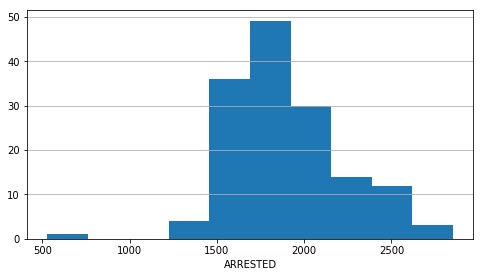

In [122]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.hist(Data)
plt.grid(b=True, which='major', axis='y')
plt.xlabel('ARRESTED')
pass

#### Notem que lemos o histograma da seguinte maneira: em cerca de 50 meses foram observadas entre 1750 e 2000 prisões. Porém, não sabemos precisar em quais meses houve um aumento ou redução das prisões. Isso deve ser observado através de um gráfico de linha.

#### **(3e) Box-plot**

#### O Box-plot é um gráfico muito utilizado em estatística para visualizar o resumo estatístico de uma variável.

#### Para esse exercício vamos plotar duas box-plot sobre a média do número de prisões durante os meses analisados para os crimes do tipo *ROBBERY* e *ASSAULT*.

#### O mapeamento é exatamente o mesmo do exercício anterior, porém filtrando para o tipo de roubo analisado.

In [123]:
# EXERCICIO

parseDayMonth = lambda x: '{}-{}'.format(x.month,x.year)

bookedRDD = (CrimeHeadlessRDD
             .filter(lambda x: u'"ARREST' in x.Resolution)#<COMPLETAR>
             .map(lambda y:(parseMonthYear(y.Dates),1))#<COMPLETAR>
             .reduceByKey(add)#<COMPLETAR>
             .map(lambda z:z[1])#.<COMPLETAR>
            )


robberyBookedRDD = (CrimeHeadlessRDD
                    .filter(lambda x: u'"ARREST' in x.Resolution and x.Category == "ROBBERY")#<COMPLETAR>
                    .map(lambda y:(parseMonthYear(y.Dates),1))#<COMPLETAR>
                    .reduceByKey(add)#<COMPLETAR>
                    .map(lambda z:z[1])#.<COMPLETAR>
                   )

assaultBookedRDD = (CrimeHeadlessRDD
                    .filter(lambda x: u'"ARREST' in x.Resolution and x.Category == "ASSAULT")#<COMPLETAR>
                    .map(lambda y:(parseMonthYear(y.Dates),1))#<COMPLETAR>
                    .reduceByKey(add)#<COMPLETAR>
                    .map(lambda z:z[1])#.<COMPLETAR>
                   )

robData = robberyBookedRDD.collect()
assData = assaultBookedRDD.collect()

In [124]:
assert robData[0]==27,'valores incorretos'
print 'ok'
assert assData[0]==152,'valores incorretos'
print 'ok'

ok
ok


#### No gráfico abaixo, percebemos que existem, em média, muito mais prisões para o tipo *ASSAULT* do que o tipo *ROBBERY*, ambos com pequena variação.

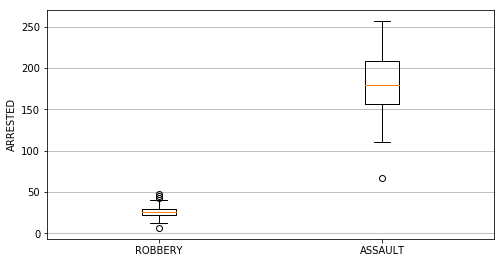

In [125]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.boxplot([robData,assData])
plt.grid(b=True, which='major', axis='y')
plt.ylabel('ARRESTED')
plt.xticks([1,2], ['ROBBERY','ASSAULT'])
pass